# Lab 8: Natural Language Processing and Text Data

In this lab, we will learn a few techniques to approach problems involving text. This fundamental topic since textual data is widespread. 

We will start by introducing text data, and some use cases of Machine Learning and Deep Learning applied to text prediction. Then we will explore the traditional approach to text problems: the **Bag of Words** (BOW) approach. 

This topic will take us to explore how to extract features from a text. We will introduce new techniques to do this as well as a couple of new Python packages specifically designed to deal with text data.

We will explore the limitations of the BOW approach and see how Neural Networks can help to overcome them. In particular, we will look at embeddings to encode text and at how to use them in Keras. Let's get started!

## Use cases

As noted in the introduction text data is encountered in many applications. Let's take a look at a few of them. We are all familiar with **Spam Detection**. It is a text classification problem where we try to distinguish legitimate documents from spammy ones. 

Spam detection involves email spam, SMS spam, instant messaging spam and in general any corpus of messages. The problem is as a binary classification where one has two sets of documents: the spam messages and the "ham" messages, i.e., the legitimate messages that we would like to keep. 

A similar binary classification problem involving text is that of **Sentiment Analysis**. 

Imagine you are a rock star tweeting about your latest album. Millions of people will reply to your tweet, and it will be impossible for you to read all of the messages from your fans. You would like to capture the overall sentiment of your fan base and see if they are happy about what you tweeted. 

Sentiment analysis does that by classifying a piece of text as having *positive* or *negative* overall sentiment. If you know the sentiment for each tweet, it's easy to extract results like: "74% of your fans responded positively to your tweet".

Many fields use Sentiment Analysis including stock trading, e-commerce reviews, customer service and in general any website or application where users are allowed to submit free-form text comments.

![Text problems](./assets/text_problems.png)

Extending beyond classification problems, we can consider regression problems involving text, for example extracting a score, a price, or any other metric starting from a text document. An example of this would be estimating the number of followers your tweet will generate based on its text content or predicting the number of downloads your application will do based on the content of a blog article.

All the above problems are traditional Machine Learning problems where text is the input to the problem. Text can also be the output of a Machine Learning problem. For example, **Machine Translation** involves converting text from a language to another. It is a supervised, many-to-many, sequence learning problem, where we feed pairs of sentences in two languages to a model that learns to generate the output sequence (for example a sentence in English), given a particular input sequence (the corresponding sentence in Italian).

Machine translation is an example of a whole category of Machine Learning problems involving text: problems involving **automatic text generation**. Another famous example in this category is that of **Language Modeling**.

In Language Modeling a _corpus of documents_ (see next section for a proper definition) is fed sequentially to a model. The model will learn the probability distribution of a specific word to appear after a sentence. The model is then sampled randomly and is capable of producing sentences that resemble the properties of the corpus. Using this approach people had models produce new sonnets from Shakespeare, [new labs of Harry Potter](https://medium.com/deep-writing/harry-potter-written-by-artificial-intelligence-8a9431803da6), [new episodes of popular novels](https://medium.com/deep-writing/silicon-valley-a-new-episode-written-by-ai-a8f832645bc2) and so on.

Since Language Modeling works on sequences, we can also build character level models that learn the syntax or our input corpus. In this way, we can produce syntactically correct markup languages like HTML, Wiki, Latex and even C! See the [wonderful article by Andrej Karpathy](https://karpathy.github.io/2015/05/21/rnn-effectiveness/) for a few examples of this.

It is clear that text is involved in several useful application. So let's see how to prepare text documents for Machine Learning.

## Text Data

### Loading text data

Text data is usually a collection of articles or documents. Linguists call this collection a [**corpus**](https://en.wikipedia.org/wiki/Text_corpus) to indicate that it's coherent and organized. For example, we could be dealing with the corpus of patents from our company or with a corpus of articles from a news platform.

The first thing we are going to learn is how to load text data using Scikit-Learn. We will build a simple Spam detector to separate SMS containing spam from legitimate SMS messages. The data comes from the [UCI SMS Spam collection](https://archive.ics.uci.edu/ml/datasets/sms+spam+collection), but it is re-organized and compressed.

The file `data/sms.zip` is a compressed archive of a folder with the structure:

    sms
     |-- ham
     |    |-- msg_000.txt
     |    |-- msg_001.txt
     |    |-- msg_003.txt
     |    +-- ...
     |
     +-- spam
          |-- msg_002.txt
          |-- msg_005.txt
          |-- msg_008.txt
          +-- ...

Let's extract all the data into the data folder:

First, let's import the `zipfile` package from Python so that we can extract the data into folders:

In [1]:
import zipfile

`zipfile` allows to operate directly zipped folder into our workspace. Have a look at the [documentation](https://docs.python.org/2/library/zipfile.html) for further details.  Here we use it to extract the data for later loading it:

In [2]:
with zipfile.ZipFile('../data/sms.zip', 'r') as fin:
    fin.extractall('../data/')

This last operation created a folder called `sms` inside the `data` folder. Let's look at its content. The `os` module contains many functions to interact with the host system. Let's import it:

In [3]:
import os

And let's use the command `os.listdir` to look at the content of the folder:

In [4]:
os.listdir('../data/sms')

['ham', 'spam']

As expected there are two subfolders: `ham` and `spam`. We can count how many files they contain with the help of the following little function that lists the content of `path` and uses a filter to only count files.

In [5]:
from os.path import isfile, join

In [6]:
def count_files(path):
    files_list = [name for name in os.listdir(path)
                  if isfile(join(path, name))]
    return len(files_list)

Let's use this function to count the number of files in the folders:

In [7]:
ham_count = count_files('../data/sms/ham/')
ham_count

4825

In [8]:
spam_count = count_files('../data/sms/spam/')
spam_count

747

We have 4825 ham files and 747 spam files. We can use these numbers to establish a baseline for our classification efforts:

In [9]:
baseline_acc = ham_count / (ham_count + spam_count)
print("Baseline accuracy: {:0.3f}".format(baseline_acc))

Baseline accuracy: 0.866


If we always predicted the large class, i.e. we never predicted spam, we would be correct 86.6% of the time. Our model needs to score higher than that to be of any help.

Let's also look at a couple of examples of our messages for each class:

In [10]:
def read_file(path):
    with open(path) as fin:
        msg = fin.read()
    return msg

In [11]:
read_file('../data/sms/ham/msg_000.txt')

'Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...'

In [12]:
read_file('../data/sms/ham/msg_001.txt')

'Ok lar... Joking wif u oni...'

In [13]:
read_file('../data/sms/spam/msg_002.txt')

"Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's"

In [14]:
read_file('../data/sms/spam/msg_005.txt')

"FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, £1.50 to rcv"

As expected, spam messages look quite different from ham messages. In order to start building a spam detection model, let's first load all the data into a dataset.

Scikit Learn offers a function to load text data from folders for classification purposes. Let's use the `load_files` function from `sklearn.datasets` package:

In [15]:
from sklearn.datasets import load_files

In [16]:
data = load_files('../data/sms/', encoding='utf-8')

`data` is an object of type:

In [17]:
type(data)

sklearn.utils.Bunch

The documentation for a `Bunch` reads:

    vocabulary-like object, the interesting attributes are: either
        data, the raw text data to learn, or 'filenames', the files
        holding it, 'target', the classification labels (integer index),
        'target_names', the meaning of the labels, and 'DESCR', the full
        description of the dataset.

so let's look at the available keys:

In [18]:
data.keys()

dict_keys(['data', 'filenames', 'target_names', 'target', 'DESCR'])

Following the documentation, let's assign the `data.data` and `data.target` to two variables `docs` and `y`.

In [19]:
docs = data.data

The first five text examples in our `docs` variable are:

In [20]:
docs[:5]

['Hi Princess! Thank you for the pics. You are very pretty. How are you?',
 "Hello my little party animal! I just thought I'd buzz you as you were with your friends ...*grins*... Reminding you were loved and send a naughty adoring kiss",
 'And miss vday the parachute and double coins??? U must not know me very well...',
 'Maybe you should find something else to do instead???',
 'What year. And how many miles.']

In [21]:
y = data.target

The first five entries in our `y` variable:

In [22]:
y[:5]

array([0, 0, 0, 0, 0])

Before we do anything else, let's save the data we have loaded as a DataFrame, just in case we need to reload it later. As usual we import our common files:

In [23]:
with open('common.py') as fin:
    exec(fin.read())

In [24]:
with open('matplotlibconf.py') as fin:
    exec(fin.read())

and then create a Dataframe with all the documents

In [25]:
df = pd.DataFrame(docs, columns=['message'])
df['spam'] = y
df.head()

,message,spam
0,Hi Princess! Thank you for...,0
1,Hello my little party anim...,0
2,And miss vday the parachut...,0
3,Maybe you should find some...,0
4,What year. And how many mi...,0


Pandas allows to save a dataframe to a variety of different formats, including Excel, CSV and SAS. We will export to CSV:

In [26]:
df.to_csv('../data/sms_spam.csv',
          index=False,
          encoding='utf8')

### Feature extraction from text

A Machine Learning algorithm is not able to deal with text as it is. Instead, we need to extract features from the text!

![Feature extraction from text](./assets/text_features.png)

Let's begin with a naive solution and gradually build up to a more complex one. The simplest way to build features from a text is to use the counts of certain words that we assume to carry information about the problem.

For example, spam messages often offer something for free or give a link to some service. Since these are SMS messages, this link will likely be a number. With these two ideas in mind, let's build a very simple classifier that uses only two features:

- The count of the occurrence of the word "_free_".
- The number of numerical characters.

Notice that our text contains uppercase and lowercase words, so as a preprocessing step let's convert everything to lowercase so we don't include meaningless features.

In [27]:
docs_lower = [d.lower() for d in docs]

The first five entries in our `docs_lower` variable are:

In [28]:
docs_lower[:5]

['hi princess! thank you for the pics. you are very pretty. how are you?',
 "hello my little party animal! i just thought i'd buzz you as you were with your friends ...*grins*... reminding you were loved and send a naughty adoring kiss",
 'and miss vday the parachute and double coins??? u must not know me very well...',
 'maybe you should find something else to do instead???',
 'what year. and how many miles.']

We can define a simple helper function that counts the occurrences of a particular word in a sentence:

In [29]:
def count_word(word, sentence):
    tokens = sentence.split()
    return len([w for w in tokens if w == word])

and apply it to each document:

In [30]:
free_counts = [count_word('free', d) for d in docs_lower]
df = pd.DataFrame(free_counts, columns=['free'])

In [31]:
df.head()

,free
0,0
1,0
2,0
3,0
4,0


Similarly let's build a helper function that counts the numerical character in a sentence using the `re` package:

In [32]:
import re

In [33]:
def count_numbers(sentence):
    return len(re.findall('[0-9]', sentence))

In [34]:
df['num_char'] = [count_numbers(d) for d in docs_lower]

In [35]:
df.head()

,free,num_char
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0


#### Spam classification

Notice that most messages don't contain our special features, so we don't expect any model to work super well in this case, but let's try to build one anyways. First, let's import the `train_test_split` function from `sklearn` as well as the the usual `Sequential` model and the `Dense` layer:

In [36]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

Now let's define the helper function that follows the usual process that we repeated several times in the previous labs:

- Train/test split
- Model definition
- Model training
- Model evaluation on test set

We will use a simple [Logistic Regression model](./03_Machine_Learning.ipynb#Logistic-Regression) to start, to make things simple and quick:

In [37]:
def split_fit_eval(X, y, model=None,
                   epochs=10,
                   random_state=0):
    X_train, X_test, y_train, y_test = \
    train_test_split(X, y, random_state=random_state)
    
    if not model:
        model = Sequential()
        model.add(Dense(1, input_dim=X.shape[1],
                        activation='sigmoid'))

        model.compile(loss='binary_crossentropy',
                      optimizer='adam',
                      metrics=['accuracy'])
    
    h = model.fit(X_train, y_train,
                  epochs=epochs,
                  verbose=0)
    
    loss, acc = model.evaluate(X_test, y_test)
    
    return loss, acc, model, h

Executing the function with our values, we'll capture the result in a variable we'll call `res`:

In [38]:
res = split_fit_eval(df.values, y)

1393/1393 [==============================] - 0s 84us/sample - loss: 0.3055 - accuracy: 0.9713


Let's check the accuracy of our model:

In [39]:
print("Simple model accuracy: {:0.3f}".format(res[1]))

Simple model accuracy: 0.971


Despite our initial skepticism, this dataset is easy to separate! It is so easy that two simple features  (the counts of the word `free` and the count of numerical characters) already achieve a much better accuracy score than the baseline, that was 0.866.

### Bag of Words features

We can extend the simple approach of the previous model in a few ways:

- We could build a vocabulary with more than just one word, and build a feature for each of them which counts how many times that word appears.
- We could filter out common English words.

Scikit Learn has a transformer that does exactly these two tasks, it's called [`CountVectorizer`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html). Let's import it from `sklearn.feature_extraction.text`:

In [40]:
from sklearn.feature_extraction.text \
    import CountVectorizer

Let's plan on using the top 3000 most common words in the corpus; this is going to be our **vocabulary size**: 

In [41]:
vocab_size = 3000

Then we can initialize the vectorizer. Here we have to use the additional argument `stop_words='english'` that tells the vectorizer to **ignore common English stop words**. We do this because we are ranking features starting from the most common word. If we didn't ignore common words, we would end up with word features like "if", "and", "of" and so on, at the top of our list, since these words are just ubiquitous in the English language. However, these words do not carry much meaning about spam and by ignoring them we get word features that are more specific to our corpus.

We are also going to ignore decoding errors using the `decode_error='ignore'` argument:

In [42]:
vect = CountVectorizer(decode_error='ignore',
                       stop_words='english',
                       lowercase=True,
                       max_features=vocab_size)

Notice that it also allows for automatic lowercase conversion. You can check what are the stop words using the `.get_stop_words()` method. Let's look at a few of them:

In [43]:
stop_words = list(vect.get_stop_words())

In [44]:
stop_words[:10]

['rather',
 'every',
 'thru',
 'next',
 'found',
 'cannot',
 'i',
 'themselves',
 'side',
 'whom']

Now that we have created the vectorizer, let's apply it to our corpus:

In [45]:
X = vect.fit_transform(docs)
X

<5572x3000 sparse matrix of type '<class 'numpy.int64'>'
	with 37142 stored elements in Compressed Sparse Row format>

`X` is a [sparse matrix](https://en.wikipedia.org/wiki/Sparse_matrix) i.e. a matrix in which most of the elements are 0. This makes sense since most messages are short and they will only contain a few of the 3000 words in our feature list. The `X` matrix has 5572 rows (i.e. the total number of sms) and 3000 columns (i.e. the total number of selected words) but only 37142 non-zero entries (less then 1%).

To use it for Machine Learning we will convert it to a dense matrix, which we can do by calling `todense()` on the object:

In [46]:
Xd = X.todense()

> TIP: be careful with converting sparse matrices to dense. If you are dealing with large datasets, you will quickly run out of memory with all those zeros. In those cases, we do on-the-fly conversion to dense of each batch during Stochastic Gradient Descent.

Let's also have a look at the features found by the vectorizer:

In [47]:
vocab = vect.get_feature_names()

The features are listed in alphabetical order:

In [48]:
vocab[:10]

['00',
 '000',
 '02',
 '0207',
 '02073162414',
 '03',
 '04',
 '05',
 '06',
 '07123456789']

In [49]:
vocab[-10:]

['yogasana', 'yor', 'yr', 'yrs', 'yummy', 'yun', 'yunny', 'yuo', 'yup', 'zed']

Let's use the helper function we've defined above to train a model on the new features:

In [50]:
res = split_fit_eval(Xd, y)

1393/1393 [==============================] - 0s 90us/sample - loss: 0.1831 - accuracy: 0.9713


In [51]:
print("Test set accuracy:\t{:0.3f}".format(res[1]))

Test set accuracy:	0.971


The accuracy on the test set is not much higher than our simple model, however, we can use this model to look for features importances, i.e. to identify words whose weight is high when predicting spam or not. Let's recover the trained model from the `res` object returned by our custom function:

In [52]:
model = res[2]

Then let's put the weights in a Pandas Series, indexed by the vocabulary:

In [53]:
w_ = model.get_weights()[0].ravel()
vocab_weights = pd.Series(w_, index=vocab)

Let's look at the top 20 words with positive weights:

In [54]:
vocab_weights.sort_values(ascending=False).head(20)

txt         0.642381
www         0.540770
claim       0.531602
mobile      0.523435
free        0.502965
150p        0.492700
              ...   
stop        0.402874
1000        0.396701
ringtone    0.389498
com         0.380621
text        0.380217
contact     0.370922
Length: 20, dtype: float32

Not surprisingly we find here words like `www`, `claim`, `prize`, `cash` etc. Similarly we can look at the bottom 20 words:

In [55]:
vocab_weights.sort_values(ascending=False).tail(20)

lol     -0.448763
wat     -0.453553
sure    -0.457073
did     -0.460798
doing   -0.473974
yeah    -0.474591
           ...   
sorry   -0.493651
going   -0.527029
ll      -0.527689
da      -0.542279
ok      -0.580417
come    -0.587829
Length: 20, dtype: float32

and see they are pretty common legitimate words like `sorry`, `ok`, `lol`, etc... If we were spammer we could take advantage of this information and craft messages that attempt to fool these simple features by using a lot of words like `sorry`or `ok`. This is a typical **Adversarial Machine Learning** scenario, where the target is constantly trying to beat the model.

In any case, it's pretty clear that this dataset is an easy one. So let's load a new dataset and learn a few more tricks!

#### Word frequencies

In the previous spam classification problem, we used a `CountVectorizer` transformer from Scikit Learn to produce a sparse matrix with term counts of the top 3000 words. Using the absolute counts was ok with SMS messages because they have a maximum length of 160 characters. In the general case, using absolute counts may be a problem if we deal with documents of uneven length. Think of a brief email versus a long article, both about the topic of AI. The word AI will appear in both documents, but it will likely be repeated more times in the long article. Using the counts would lead us to think that the article is more about AI than the short email, while it's simply a longer text.
We can account for that using the **term frequency** instead of the count, i.e., by dividing the counts by the length of the document. Using term frequencies is already an improvement, but we can do even better.

There will be some words that are common in every document. These could be [common English stop words](https://en.wikipedia.org/wiki/Stop_words), but they could also be words that are common across the specific corpus. For example, if we are trying to sort a corpus of patents by topics, it is clear that words like _patent_, _application_, _grant_ and similar legal terms will be shared across the whole corpus and not indicative of the particular topic of each of the documents in the corpus.

We want to normalize our term frequencies with a term inversely proportional to the fraction of documents containing that term, i.e., we want to use an **inverse document frequency**.

These features go by the name of [TF-IDF](https://en.wikipedia.org/wiki/Tf%E2%80%93idf), i.e., **term-frequency–inverse-document-frequency**, which is also available as a vectorizer in Scikit Learn.

In other words, TF-IDF features look like:

```python
TFIDF(word, document) = counts_in_document(word, document) /  counts_of_documents_with_word_in_corpus(word)
```

or using maths:
\begin{equation}
\text{tf-idf}(w, d)=\frac{\text{tf}(w, d)}{\text{df}(w, d)}
\end{equation}

where $w$ is a word, $d$ is a document, $\text{tf}$ stands for "term frequency" and $\text{df}$ for "document frequency".

As you can read in the [Wikipedia](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) article, there are several ways to improve the above of the _TF-IDF_ formula, using different regularization schemes. [Scikit Learn implements it as follows](https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction):

\begin{equation}
\text{tf-idf}(w, d)=\text{tf}(w, d) \times \log{\left(\frac{1 + n_d}{1+\text{df}(w, d)}\right)} + 1
\end{equation}

where $n_d$ is the total number of documents and the regularized logarithm takes care of words that are extremely rare or extremely common.

### Sentiment classification

Let's load a new dataset, containing reviews from the popular website [Rotten Tomatoes](https://www.rottentomatoes.com/):

In [56]:
df = pd.read_csv('../data/movie_reviews.csv')
df.head()

,title,review,vote
0,Toy story,"So ingenious in concept, d...",fresh
1,Toy story,The year's most inventive ...,fresh
2,Toy story,A winning animated feature...,fresh
3,Toy story,The film sports a provocat...,fresh
4,Toy story,An entertaining computer-g...,fresh


Let's take a peek into the data we loaded, see how many reviews we have and a few other pieces of information.

In [57]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14072 entries, 0 to 14071
Data columns (total 3 columns):
title     14072 non-null object
review    14072 non-null object
vote      14072 non-null object
dtypes: object(3)
memory usage: 329.9+ KB


Let's look at the division between the `fresh` votes, the `rotten`, and the `none` votes.

In [58]:
df['vote'].value_counts() / len(df)

fresh     0.612067
rotten    0.386299
none      0.001634
Name: vote, dtype: float64

As you can see, the dataset contains reviews about famous movies and a judgment of `rotten` VS `fresh`, which is the class we will try to predict.

First of all, we notice that a small number of reviews do not have a class, so let's eliminate those few rows from the dataset. We'll do this by selecting all the `votes` that are _not_ `none`:

In [59]:
df = df[df.vote != 'none'].copy()

In [60]:
df['vote'].value_counts() / len(df)

fresh     0.613069
rotten    0.386931
Name: vote, dtype: float64

Our reference accuracy is 61.3%, the fraction of the larger class.

#### Label encoding

Notice that the labels are strings, and we need to convert them to 0 and 1 in order to use them for classification. We could do this in many ways, one way is to use the [`LabelEncoder`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html) from Scikit Learn. It is a transformer that will look at the unique values present in our label column and encode them to numbers from 0 to $N-1$, where $N$ is the number of classes, in our case 2.

Let's first import it from `sklearn.preprocessing`:

In [61]:
from sklearn.preprocessing import LabelEncoder

Let's instantiate the `LabelEncoder`:

In [62]:
le = LabelEncoder()

Finally, let's create a vector of 0s and 1s that represent the features:

In [63]:
y = le.fit_transform(df['vote'])

`y` is now a vector of 0s and 1s. Let's look at the first 10 entries:

In [64]:
y[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

#### Bag of words: TF-IDF features

Let's import the `TfidfVectorizer` vector from Scikit Learn:

In [65]:
from sklearn.feature_extraction.text import TfidfVectorizer

Let's initialize it to look at the top 10000 words in the corpus, excluding English stop words:

In [66]:
vocab_size = 10000

vect = TfidfVectorizer(decode_error='ignore',
                       stop_words='english',
                       max_features=vocab_size)

We can use the vectorizer to transform our reviews:

In [67]:
X = vect.fit_transform(df['review'])

In [68]:
X

<14049x10000 sparse matrix of type '<class 'numpy.float64'>'
	with 130025 stored elements in Compressed Sparse Row format>

This generates a sparse matrix with 14049 rows and 10000 columns. This is still small enough to be converted to dense and passed to our model evaluation function. Let's call `todense()` on the object to convert it to a dense matrix:

In [69]:
Xd = X.todense()

Let's train our model. We will use a higher number of epochs in this case, to ensure convergence with the larger dataset:

We'll use our function again:

In [70]:
res = split_fit_eval(Xd, y, epochs=30)

3513/3513 [==============================] - 0s 86us/sample - loss: 0.5133 - accuracy: 0.7504


In [71]:
print("Test set accuracy:\t{:0.3f}".format(res[1]))

Test set accuracy:	0.750


The accuracy on the test set is much lower than the last value of accuracy obtained on the training set (last line printed during training), therefore the model is overfitting. This is not unexpected given the large number of features. Despite the overfitting, the test score is still higher than the 61.3% accuracy obtained by always predicting the larger class.

### Text as a sequence

The bag of words approach is very crude. It does not take into account context, i.e. each word is treated as independent feature, regardless of its position in the sentence. This is particularly bad for tasks like sentiment analysis where negations could be present ("This movie was not good") and the overall sentiment could not be carried by any particular word.

To go beyond the bag of words approach, we need to treat the text as a sequence instead of just looking at frequencies. To do this, we will proceed to:

1. create a vocabulary, indexed starting from the most frequent word and then continuing in decreasing order.
2. convert the sentences into sequences of integer indices using the dictionary
3. feed the sequences to a Neural Network to perform the sentiment classification

Keras has a preprocessing [`Tokenizer`](https://keras.io/preprocessing/text/) that allows us to create a vocabulary and convert the sentences using it. Let's load it:

In [72]:
from tensorflow.keras.preprocessing.text import Tokenizer

Let's initialize the `Tokenizer`. We will use the same vocabulary size of 10000 used in the previous task:

In [73]:
vocab_size

10000

In [74]:
tokenizer = Tokenizer(num_words=vocab_size)

We can fit the tokenizer on our reviews using the function `.fit_on_texts`. We will pass the column of the dataframe `df` that contains the reviews:

In [75]:
tokenizer.fit_on_texts(df['review'])

Great! The tokenizer has finished its job, so let's give a look at some of its attributes.

The `.document_count` gives us the number of documents used to build the vocabulary:

In [76]:
tokenizer.document_count

14049

These are the 14049 reviews left in the dataset after we removed the ones without a vote. The `.num_words` attribute gives us the number of features in the vocabulary. These should be 10000:

In [77]:
tokenizer.num_words

10000

Finally, we can retrieve the word index by calling `.word_index`, which returns an vocabulary. Let's look at the first 10 items in it:

In [78]:
list(tokenizer.word_index)[:10]

['the', 'a', 'and', 'of', 'to', 'is', 'in', 'it', 'that', 'as']

As you can see this is not sorted alphabetically, but in decreasing order of frequency starting from the most common word. Let's use the tokenizer to convert our reviews to sequences. For instance, "The movie is great" translates to the sequence `1539`:

![Conversion of words to indices](./assets/word_to_index.png)

In [79]:
sequences = tokenizer.texts_to_sequences(df['review'])

`sequences` is a list of lists. Each of the inner lists is one of the reviews:

In [80]:
sequences[:3]

[[36,
  1764,
  7,
  1058,
  800,
  3,
  1765,
  9,
  27,
  151,
  268,
  8,
  21,
  2,
  9088,
  3879,
  5881,
  115,
  3,
  101,
  20,
  22,
  17,
  360],
 [1, 610, 38, 801, 49],
 [2, 1012, 347, 225, 9, 24, 107, 14, 564, 21, 1, 354, 7122]]

Let's just double check that the conversion is correct by converting the first list back to text. We will need to use the reverse `index -> word` map:

In [81]:
tok_items = tokenizer.word_index.items()
idx_to_word = {i:w for w, i in tok_items}

The first review is:

In [82]:
df.loc[0, 'review']

'So ingenious in concept, design and execution that you could watch it on a postage stamp-sized screen and still be engulfed by its charm.'

The first sequence is:

In [83]:
' '.join([idx_to_word[i] for i in sequences[0]])

'so ingenious in concept design and execution that you could watch it on a postage stamp sized screen and still be by its charm'

The two sentences are almost identical, however notice a couple of things:

1. punctuation has been stripped away in the tokenization.
- all words are lowercased.
- some really rare word (e.g. "engulfed") are out of our top 3000 words and are therefore ignored.

Now that we have sequences of numbers, we can organize them into a matrix with one review per row and one word per column. Since not all sequences have the same length, we will need to pad the short ones with zeros.

Let's calculate the longest sequence length:

In [84]:
maxlen = max([len(seq) for seq in sequences])
maxlen

49

The longest review contains 49 words. Let's pad every other review to 49 using the [`pad_sequences`](https://keras.io/preprocessing/sequence/) function from Keras:

In [85]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

As you can read in the documentation:

```python
Signature: pad_sequences(sequences, maxlen=None, dtype='int32',
                         padding='pre', truncating='pre', value=0.0)
Docstring:
Pads each sequence to the same length (length of the longest sequence).

If maxlen is provided, any sequence longer
than maxlen is truncated to maxlen.
```

`pad_sequences` operates on the sequences by padding and truncating them. Let's set the `maxlen` parameter to the value we already found:

In [86]:
X = pad_sequences(sequences, maxlen=maxlen)

In [87]:
X.shape

(14049, 49)

`X` has 14049 rows (i.e., the number of samples, review in this case) and 49 columns (i.e., the words of the longest review). Let's print out the first few reviews:

In [88]:
X[:4]

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,   36, 1764,    7, 1058,  800,    3, 1765,    9,
          27,  151,  268,    8,   21,    2, 9088, 3879, 5881,  115,    3,
         101,   20,   22,   17,  360],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           1,  610,   38,  801,   49],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    2, 1012,  347,  225,    9,   24,  107,   14,
         564,   21,    1,  354, 71

Can we feed this matrix to a Machine Learning model? Let's think about it for a second. If we treat this matrix as tabular data, it would mean each column represents a feature. What feature? Columns in the matrix correspond to the position of the word in a sentence, and so there's absolutely no reason why two words appearing at the same position would carry consistent information about sentiment.

Also, the numbers here are the indices of our words in a vocabulary, so their actual value is not a quantity, it's their rank in order of frequency in the dictionary. In other words, word number 347 is not 347 times as large as the word at index 1; it's just the word that appears at index 347 in the vocabulary.

The correct way to think of this data is to recognize that each number in `X` really represents an index in a vector with length `vocab_size`, i.e., a vector with 10000 entries. These are the actual features, i.e., all the words in our vocabulary.

So, this matrix is a shorthand for an order-3 sparse tensor whose three axes are (sentence, position along the sentence, word feature index). The first axis would locate the sentence in the dataset, and it corresponds to the row axis of our `X` matrix. The second axis would locate the word position in the sentence, and it corresponds to the column axis of our `X` matrix. The third would be a sparse vector, locate the word in the vocabulary. Instead of using a sparse vector, we use the index of the word in the dictionary, which is the value in that specific entry in the  `X`  matrix.

![1-hot encoding of words](./assets/word_to_index_to_1_hot.png)

It looks like one way to feed this data to a Neural Network would be to expand the `X` matrix to a 1-hot encoded order-3 tensor with 0s and 1s, and then feed this tensor to our network, for example to a [Recurrent layer](7_Time_Series_and_Recurrent_Neural_Networks.ipynb#Recurrent-Neural-Network) with `input_shape=(49, 10000)`. This would be the equivalent of feeding a dataset of 10000 time series, whose elements are all mostly zeros, except for one at each time, which is not zero when that word occurs in that particular sentence.

While this encoding works, it is not really memory efficient. Besides that, representing each word along a different orthogonal axis in a 10000-dimensional vector space doesn't capture any information on how that word is used in its context. How can we improve this situation?

One idea would be to insert a fully connected layer to compress our input space from the vast sparse vector space of 10000 words in our vocabulary to a much smaller, dense, vector space, for example with just 32 axes. In this new space, each word is represented by a dense vector, whose entries are floating point numbers instead of all 0s and a single 1.

![Dense representation of words with vectors](./assets/word_dense.png)

This is cool because now we can feed our sequences of much smaller dense vectors to a recurrent network to complete the sentiment classification task, i.e., we are treating the sentiment classification problem as a [Sequence Classification problem](./07_Time_Series_and_Recurrent_Neural_Networks.ipynb#Sequence-Classification) like the ones encountered in Lab 7.

Furthermore, since the dense vector comes from a fully connected layer, we can jointly train the fully connected layer and the recurrent layer allowing the fully connected layer to find the best representation for the words to help the recurrent layer achieve its task.

#### Embeddings

In practice, we never actually go through the burden of converting the word indices to 1-hot vectors and then back to dense vectors. We use an **Embedding layer**. In this layer, we specify the output dimension, i.e., the length of the dense vector, and it has an independent set of as many weights for each of the words in the vocabulary. So, for example, if the vocabulary is 10000 words and we specify an output dim of 100, the embedding layer will carry 1000000 weights, 100 for each of the words in the vocabulary.

The numbers in the input indicate the indices that select the set of 100 weights for each word, i.e., they will be interpreted as indices in a phantom sparse space, saving us from converting the data to 1-hot and then converting it back to dense.

![Embedding vectors](./assets/word_embedding.png)

Let's see how to include this in our network. Let's load the [`Embedding`](https://keras.io/layers/embeddings/) layers from Keras:

In [89]:
from tensorflow.keras.layers import Embedding

Let's see how it works by creating a network with a single such layer that maps a feature space of 100 words to an output dense space of only two dimensions:

In [90]:
model = Sequential()
model.add(Embedding(input_dim=100, output_dim=2))
model.compile(optimizer='sgd',
              loss='categorical_crossentropy')

The network above assumes the inputs are numbers between 0 and 99. We interpret these as the indices of the single non-zero entry in a 100-dimensional 1-hot vector. Sequences of such indices will be interpreted as sequences of such vectors and will be transformed to sequences 2-dimensional dense vectors since 2 is the dimension of the output space.

Let's feed a single sequence of a few indices and perform a forward pass:

In [91]:
model.predict(np.array([[ 0, 81,  1, 0, 79]]))

array([[[-0.03956728,  0.03056333],
        [-0.04755666,  0.01909782],
        [ 0.04237584,  0.00242125],
        [-0.03956728,  0.03056333],
        [ 0.01191726,  0.02468473]]], dtype=float32)

The embedding layer turned the sequence of five numbers into a sequence of five 2-dimensional vectors. Since we have not trained our Embedding Layer yet, these are just the weight vectors corresponding to each word, so for example, words `0` corresponds to the weights `[-0.03977597, -0.01466479]`. Notice how these appear both on the first row and the fourth row, exactly as one would expect since the words `0` appears at the first and fourth positions in our five words sentence.

Similarly, if we feed a batch of few sequences of indices, we will obtain a batch of few sequences of vectors, i.e., a tensor of order three, with axes `(sentence, position in the sentence, embedding)`:

In [92]:
model.predict(np.array([[ 0, 81,  1, 96, 79],
                        [ 4, 17, 47, 69, 50],
                        [15, 49,  3, 12, 88]]))

array([[[-0.03956728,  0.03056333],
        [-0.04755666,  0.01909782],
        [ 0.04237584,  0.00242125],
        [-0.02041857,  0.0362685 ],
        [ 0.01191726,  0.02468473]],

       [[-0.03104251, -0.01826168],
        [ 0.01193748,  0.01767396],
        [-0.04211649, -0.00892004],
        [ 0.01063975,  0.03848443],
        [-0.02258428,  0.01715442]],

       [[-0.01262269,  0.04034625],
        [ 0.02745339, -0.01809684],
        [-0.01439632, -0.04749357],
        [-0.04891055,  0.01495666],
        [-0.01743649, -0.01524024]]], dtype=float32)

Great! Now we know what to do to build our sentiment classifier. We will:

- Split as usual our `X` matrix of indices into train and test
- Build a network with:
    - Embedding
    - Recurrent
    - Dense
- Classify the sentiment of our reviews

Let's start from the train/test split. As we've done several times in the labs, we set `random_state=0` so that we all get the same train/test split.

> TIP: Setting the random state is useful when you want to have repeatable random splits.

In [93]:
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, random_state=0)

In [94]:
X.shape

(14049, 49)

#### Recurrent model

Let's build our model as we did in the previous lab. First, let's import the `LSTM` layer from Keras:

In [95]:
from tensorflow.keras.layers import LSTM

Next, let's build up our model. We'll create our `Embedding` layer followed by our `LSTM` layer and the regular `Dense` and `Activation` layers after that:

In [96]:
model = Sequential()
model.add(Embedding(input_dim=vocab_size,
                    output_dim=16,
                    input_length=maxlen))
model.add(LSTM(32))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

Let's train our model using the `fit()` function. We will train the model on batches of 128 reviews for 8 epochs with a 20% validation split:

In [97]:
h = model.fit(X_train, y_train, batch_size=128,
              epochs=8, validation_split=0.2)

Train on 8428 samples, validate on 2108 samples
Epoch 1/8
8428/8428 [==============================] - 2s 210us/sample - loss: 0.6651 - accuracy: 0.6140 - val_loss: 0.6524 - val_accuracy: 0.6067
Epoch 2/8
8428/8428 [==============================] - 0s 51us/sample - loss: 0.5679 - accuracy: 0.6940 - val_loss: 0.5475 - val_accuracy: 0.7353
Epoch 3/8
8428/8428 [==============================] - 0s 47us/sample - loss: 0.3983 - accuracy: 0.8379 - val_loss: 0.5708 - val_accuracy: 0.7500
Epoch 4/8
8428/8428 [==============================] - 0s 46us/sample - loss: 0.2719 - accuracy: 0.8938 - val_loss: 0.6332 - val_accuracy: 0.7519
Epoch 5/8
8428/8428 [==============================] - 0s 46us/sample - loss: 0.1926 - accuracy: 0.9286 - val_loss: 0.7121 - val_accuracy: 0.7509
Epoch 6/8
8428/8428 [==============================] - 0s 47us/sample - loss: 0.1380 - accuracy: 0.9528 - val_loss: 0.8569 - val_accuracy: 0.7434
Epoch 7/8
8428/8428 [==============================] - 0s 46us/sample - los

The model seems to be doing much better on the training set than any of the previous models based on Bag of Words, since it achieves an accuracy greater than 95% in only 10 epochs. On the other hand, the validation accuracy sees to be consistently lower, which indicates probable overfitting. Let's evaluate the model on the test set in order to verify the ability of our model to generalize:

In [98]:
loss, acc = model.evaluate(X_test, y_test, batch_size=32)
acc

3513/3513 [==============================] - 0s 73us/sample - loss: 0.9546 - accuracy: 0.7353


0.735269

Ouch! The test score is not much better than the score obtained by our BOW model. This means the model is overfitting. Let's plot the training history:

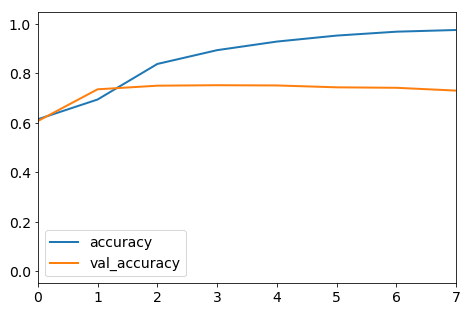

In [99]:
dfhistory = pd.DataFrame(h.history)
dfhistory[['accuracy', 'val_accuracy']].plot(ylim=(-0.05, 1.05));

As you can see, after a few of epochs the validation accuracy stops improving while the training accuracy keeps improving.

We can also look at the loss and notice that the validation loss does not decrease after a certain point, while the training loss does.

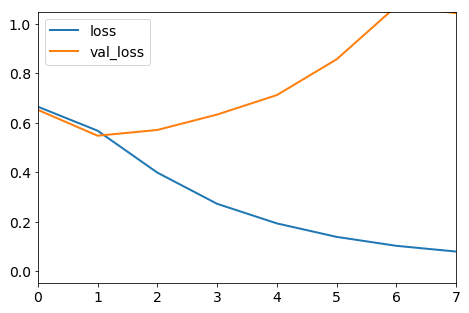

In [100]:
dfhistory[['loss', 'val_loss']].plot(ylim=(-0.05, 1.05));

How many weights are there in our model? Is it too big?

In [101]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 49, 16)            160000    
_________________________________________________________________
unified_lstm (UnifiedLSTM)   (None, 32)                6272      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 166,305
Trainable params: 166,305
Non-trainable params: 0
_________________________________________________________________


The model is quite big compared to the size of the dataset. We have over 160 thousand parameters to classify less than 15 thousand short reviews. This is not a good situation, and we expect to overfit. In the exercises, we will repeat the sentiment prediction on a larger corpus of reviews and see if we can get better results.

We will also learn another way to reduce overfitting later in the labs when we discuss pre-trained models.

## Sequence generation and language modeling

As mentioned at the beginning of this lab and in the previous one, Neural Networks are not only suited to deal with textual input data but also to generate text output. We can interpret a text as a **sequence of words**  or as a **sequence of characters** and we can use a model to predict the next character or words in a sequence. This is called **Language Modeling** and it has been successfully used to generate "Shakespeare-sounding" poems, new pages of Wikipedia and so on (see [this wonderful article by A. Karpathy](http://karpathy.github.io/2015/05/21/rnn-effectiveness/) for a few examples).

The basic idea is to apply to text the same approach we used to [improve forecasting](./07_Time_Series_and_Recurrent_Neural_Networks.ipynb#Improving-Forecasting) in the time series prediction of the last lab.

We will start from a corpus of text, split it into short, fixed-size Windows, i.e., sub-sentences with a few characters, and then train a model to predict the next character after the sequence.

> What are "windows" here? What do they refer to?

![Windows of text](./assets/text_to_windows.png)

Let's give an example by designing an RNN to generate names of babies. We will use [this corpus](http://www.cs.cmu.edu/afs/cs/project/ai-repository/ai/areas/nlp/corpora/names/) as training data, which contains thousands of names.

We start by loading all the names from `../data/names.txt`. We also add a `\n` character to allow the model to learn to predict the end of a name and convert the names to lowercase.

In [102]:
with open('../data/names.txt') as f:
    names = f.readlines()
    names = [n.lower().strip() + '\n' for n in names]

print('Loaded %d names' % len(names))

Loaded 7939 names


Let's have a look at the first three of them:

In [103]:
names[:3]

['aamir\n', 'aaron\n', 'abbey\n']

We need to count all of the characters in our "vocabulary" and build a vocabulary that translates between the character and its assigned index (and vice versa). We could do this using the `Tokenizer` from Keras, but it is so simple that we can do it by hand using a Python `set`:

In [104]:
chars = set()

for name in names:
    chars.update(name)

vocab_size = len(chars)

Let's look at the number of chars we've saved:

In [105]:
vocab_size

28

In [106]:
chars

{'\n',
 '-',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z'}

Now let's create two dictionaries, one to go fro characters to indices and the other to go back from indices to characters. We'll use these two dictionaries a bit later.

In [107]:
char_to_idx = dict((c, i) for i, c in enumerate(chars))
inds_to_char = dict((i, c) for i, c in enumerate(chars))

### Character sequences

We can use the vocabulary created above to translate each name in `names` to its number format in `int_names`. We will achieve this using a nested [list comprehension](https://docs.python.org/2/tutorial/datastructures.html#list-comprehensions) where we iterate on names and for each name we iterate on characters:

In [108]:
int_names = [[char_to_idx[c] for c in n] for n in names]

Now each name has been converted to a sequence of integers, for example, the first name:

In [109]:
names[0]

'aamir\n'

Was converted to:

In [110]:
int_names[0]

[12, 12, 13, 10, 21, 25]

Great! Now we want to create short sequences of few characters and try to predict the next. We will do this by cutting up names into input sequence of length `maxlen` and using the following character as training labels. Let's start with `maxlen = 3`:

In [111]:
maxlen = 3

name_parts = []
next_chars = []

for name in int_names:
    for i in range(0, len(name) - maxlen):
        name_parts.append(name[i: i + maxlen])
        next_chars.append(name[i + maxlen])

`name_parts` is a list with short fractions of names (three characters). Let's take a look at the first elements:

In [112]:
name_parts[:4]

[[12, 12, 13], [12, 13, 10], [13, 10, 21], [12, 12, 21]]

`next_chars` is a list with single entries, each representing the next character:

In [113]:
next_chars[:4]

[10, 21, 25, 20]

As a last step we convert the nested list of `name_parts` to an array. We can do this, using the same `pad_sequences` function used earlier in this lab. This takes the nested list and converts it to an array trimming the longer sequences and padding the shorter sequences:

In [114]:
X = pad_sequences(name_parts, maxlen=maxlen)

The final shape of our input is:

In [115]:
X.shape

(32016, 3)

i.e. we have 32016 name parts, each with 3 consecutive characters.

Now let's deal with the labels. We can use the `to_categorical` function to 1-hot encode the targets. Let's import it from `keras.utils`:

In [116]:
from tensorflow.keras.utils import to_categorical

Now let's create our categories from the `next_chars` using this function. Notice that we let Keras know how many characters are in the vocabulary by setting `num_classes=vocab_size` in the second argument of the function:

In [117]:
y = to_categorical(next_chars, vocab_size)

The shape of our labels is:

In [118]:
y.shape

(32016, 28)

i.e. we have 32016 characters, each represented by a 1-hot encoded vector of `vocab_size` length.

### Recurrent Model

At this point we are ready to design and train our model. 

We will need to set up an embedding layer for the input, one or more recurrent layers and a final dense layer with softmax activation to predict the next character. We can design the model using the Sequential API as usual, or we can start to practice with the [Functional API](https://keras.io/getting-started/functional-api-guide/), which we will use more often later on. This API is much more powerful than the [Sequential API](https://keras.io/models/sequential/) we used so far because it allows us to build models that can have more than one processing branch. It is good to start approaching it on a simple case so that we will be more familiar with it when we use it on larger and more complex models.

Let's import the `Model` class from `tensorflow.keras` and the `Input` layer:

In [119]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input

In the Functional API, each layer is a function, which receives the output of the previous layer and it returns an output to the next. When we specify a model in this way, we need to start from an `Input` layer with the correct shape.

Since we have padded our name subsequences to a length of 3, we'll create an `Input` layer with shape `(3,)`:

> TIP: remember that the trailing comma is needed in Python to distinguish a tuple with one element from a simple number within parentheses.

In [120]:
inputs = Input(shape=(3, ))

Let's look at the inputs variable we have just defined:

In [121]:
inputs

<tf.Tensor 'input_1:0' shape=(None, 3) dtype=float32>

It's a Tensorflow tensor with `shape=(?, 3)`, i.e. it will accept batches of data with 3 features, exactly as we want. Next we create the `Embedding` layer, with input dimension equals to the vocabulary size (i.e. 28) and output dimension equal to 5. 

In [122]:
emb = Embedding(input_dim=vocab_size, output_dim=5)

Next we will use this layer as a function, i.e. we well pass the `inputs` tensor to it and save the output tensor to a temporary variable called `h` (for hidden).

In [123]:
h = emb(inputs)

Note that we could have achieve the previous two operations in a single line by writing:
```python
h = Embedding(input_dim=vocab_size, output_dim=5)(inputs)
```

Following this style, we define the layer to be an `LSTM` layer with eight units, and we reuse the `h` variable for its output:

In [124]:
h = LSTM(8)(h)

Finally, we create the output layer, a `Dense` layer with as many nodes as `vocab_size` and with a Softmax activation function:

In [125]:
outputs = Dense(vocab_size, activation='softmax')(h)

Now that we have created all the layers we need and connected their inputs and outputs let's create a model. This is done using the `Model` class that needs to know what the inputs and outputs of the model are:

In [126]:
model = Model(inputs=inputs, outputs=outputs)

From here onwards we proceed in an identical way to what we've been doing with the Sequential API. We compile the model for a classification problem:

In [127]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

and now we are ready to train it. We will let the training run for at least ten epochs. While the model trains, let us reflect on a couple of questions:

- Will this model reach 99% accuracy?
- Will any model ever reach 99% accuracy on this task?
- Would this change if we had access to a corpus of millions of names?
- What accuracy would you expect from randomly guessing the next character?

Let's train our model by using the `fit()` function. We will run the training for 20 epochs:

In [128]:
model.fit(X, y, epochs=20, verbose=0);

Great! The model has finished training. Getting above 30% accuracy is a good result in this case. The reason is, we are trying to predict the next character after a sequence of three characters, but there is no unique solution to this prediction problem.

Think for example of the three characters `and`. How many names are there in the dataset that start with `and`?

- `anders` -> next char is `e`
- `andie` -> next char is `i`
- `andonis` -> next char is `o`
- `andre` -> next char is `r`
- `andrea` -> next char is `r`
- `andreas` -> next char is `r`
- `andrej` -> next char is `r`
- `andres` -> next char is `r`
- `andrew` -> next char is `r`
- `andrey` -> next char is `r`
- `andri` -> next char is `r`
- `andros` -> next char is `r`
- `andrus` -> next char is `r`
- `andrzej` -> next char is `r`
- `andy` -> next char is `y`

From this example, we see that while `r` is the most frequent answer, it's not the only one. Other letters could come after the letters `and` in our training set.

By training the model on the truncated sequences, we are effectively teaching our model a probability distribution over our vocabulary. Using the example above, given the series of characters `['a', 'n', 'd']` the model is learning that the character `r` appears 11/15 times, i.e., it has a probability of 0.733, while the characters `e`, `i`, `o`, `y` each appear 1/15 times, i.e., each has a probability of 0.066.

> TIP: For the math inclined reader, the model is learning to predict the probability  $p(c_t | c_{t-3}c_{t-2}c_{t-1})$ where the index $t$ indicates the position of a character in the name. $p(A | B)$ is the **conditional probability** of A given B. This is the probability that A will happen when B has already happened.

Since the vocabulary size is 28, if the next character would have been predicted using a random uniform distribution over the vocabulary, on average we would predict correctly only one time every 28 trials, which would give an accuracy of about 3.6%. We get to an accuracy of about 30%, which is 10x higher than random.

### Sampling from the model

Now that we trained the model, we can use it to produce new names, that should at least sound like English names. We can sample the model by feeding in a few letters and using the model's prediction for the next letter. Then we feed the model's prediction back in to get the next letter, and so on.

First of all, let's define a helper function called `sample`. This function has to take an array of probabilities $\mathbf{p} = [p_i]_{i \in \textrm{vocab}}$ for the characters in the vocabulary and return the index of a character, with probabilities according to $\mathbf{p}$. This will return more probable characters more often than characters with a lower probability.

The [**multinomial distribution**](https://en.wikipedia.org/wiki/Multinomial_distribution) is a generalization of the binomial distribution that can help us in this case. It is implemented in Numpy and its [documentation](https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.multinomial.html) reads:

    The multinomial distribution is a multivariate generalization of the
    binomial distribution.  Take an experiment with one of ``p``
    possible outcomes.  An example of such an experiment is throwing a dice,
    where the outcome can be 1 through 6.  Each sample drawn from the
    distribution represents `n` such experiments.  Its values,
    ``X_i = [X_0, X_1, ..., X_p]``, represent the number of times the
    outcome was ``i``.


This description says that if our experiment has three possible outcomes with probabilities `[0.25, 0.7, 0.05]`, a single multinomial draw will return an array of length three, where all the entries will be zero except one, that will be a 1, corresponding to the randomly chosen outcome for that experiment. If we were to repeat the draws multiple times, the frequencies of each outcome would tend towards the assigned probabilities.

Therefore we can implement the sample function as:

\begin{equation}
\textrm{sample}(p) := \textrm{argmax}(\textrm{multinomial}(1, p, 1))
\end{equation}

We are going to generalize this a bit more, introducing a parameter called **diversity** that rescales the probabilities. For high values of the diversity, the probability vectors will tend to zero, and we will be approaching the random uniform distribution. When the diversity is low, the most likely characters will be selected even more often, approaching a deterministic character generator.

Let's create the `sample` function that accepts an input list with a `diversity` argument that allows us to rescale the probabilities as an argument:

In [129]:
def sample(p, diversity=1.0):
    p1 = np.asarray(p).astype('float64')
    p1 = np.log(p1) / diversity
    e_p1 = np.exp(p1)
    s = np.sum(e_p1)
    p1 = e_p1 / s
    return np.argmax(np.random.multinomial(1, p1, 1))

Let's make sure we understand how this function works with an example. Let's define the probabilities of 3 outcomes (you may think of these as win-loose-draw) where the first one happens 1/4th of the time, the second one 65% of the time and the last one only 10% of the time.

In [130]:
probs = [0.25, 0.65, 0.1]

Drawing samples from this probability distribution we would expect to pull out the number 1 (corresponding to the second outcome) about 65% of the time and so on.
Let's sample 100 times:

In [131]:
draws = [sample(probs) for i in range(100)]

and let's use a `Counter` to count how many of each we drew:

In [132]:
from collections import Counter

In [133]:
Counter(draws)

Counter({1: 65, 2: 14, 0: 21})

As you can see our results reflect the actual probabilities, with some statistical fluctuations.

Great! Now that we can sample from the vocabulary let's generate a few names. We will start from an input *seed* of three letters and then iterate in a loop the following steps:

- Use the seed to predict the probability distribution for next characters.
- Sample the distribution using the sample function.
- Append the next character to the seed.
- Shift the input window by one to include the last character appended.
- Repeat.

The loop ends either when we reach a termination character or a pre-defined length.

Let's go ahead and build this function step by step. Let's set up the `seed` of our name to be something like `ali`. 

In [134]:
seed = 'ali'
out = seed

In order to build the name, let's create an output list (we'll call `x`) to store our output, setting the length to that of the maximum length of the name we want to generate:

In [135]:
x = np.zeros((1, maxlen), dtype=int)

Let's use a variable we'll call `stop` to stop the loop if our network predicts the `'\n'` character as the next character and set it to `False`:

In [136]:
stop = False

Finally let's loop until we have to stop:

In [137]:
while not stop:
    for i, c in enumerate(out[-maxlen:]):
        x[0, i] = char_to_idx[c]

    preds = model.predict(x, verbose=0)[0]

    c = inds_to_char[sample(preds)]
    out += c

    if c == '\n':
        stop = True
out

'alistus\n'

The network produced a few characters and then stopped. Now let's wrap these steps in a function that encapsulates this entire process in a single method. Let's call our function `complete_name`. This function will take an input *seed* of three letters and run through the previous steps to predict the next character.

In [138]:
def complete_name(seed, maxlen=3, max_name_len=None,
                  diversity=1.0):
    '''
    Completes a name until a termination character is
    predicted or max_name_len is reached.

    Parameters
    ----------
    seed : string
        The start of the name to sample
    maxlen : int, default 3
        The size of the model's input
    max_name_len : int, default None
        The maximum name length; if None then samples
        are generated until the model generates a '.'
    diversity : float, default 1.0
        Parameter to increase or decrease the randomness
        of the samples; higher = more random,
        lower = more deterministic

    Returns
    -------
    out : string
    '''
    
    out = seed
    
    x = np.zeros((1, maxlen), dtype=int)
    
    stop = False
    
    while not stop:
        for i, c in enumerate(out[-maxlen:]):
            x[0, i] = char_to_idx[c]
        
        preds = model.predict(x, verbose=0)[0]
        
        c = inds_to_char[sample(preds, diversity)]
        out += c
        
        if c == '\n':
            stop = True
        else:
            if max_name_len is not None:
                if len(out) > max_name_len - 1:
                    out = out + '\n'
                    stop = True
    return out

Nice! Now that we have a function to complete names, let's predict a few names that start as `jen`:

In [139]:
for i in range(10):
    print(complete_name('jen'))

jenlie

jenelorla

jenda

jen

jenela

jenny

jen

jenryme

jenansa

jendee



Not bad! Let's play with the _diversity_ parameter to understand what it does. If we set the diversity to be high, we get random sequences of characters:

In [140]:
for i in range(10):
    print(complete_name('jen', diversity=10,
                        max_name_len=20))

jensilregtpliodmzyti

jenq

jennortvariiejb-pawf

jensllaxfpqs

jenedbtvxlleieadxold

jen

jenfiiquxegvdqj-s-in

jencgyvopyrdceg

jene

jenllectcubvfdcifdnr



If we set it to a small value, the function becomes deterministic.

> TIP: since the `sample` function involves logarithms and exponential, it accumulates numerical errors very quickly. It would be better to build a model that predicts logits instead of probabilities, but Keras does not allow to do that. 

In [141]:
for i in range(10):
    print(complete_name('jen', diversity=0.01, 
                        max_name_len=20))

jen

jen

jen

jen

jen

jen

jen

jen

jen

jen



Awesome! We now know how to build a language model! Go ahead and unleash your powers on your author of choice and start producing new poems or stories. The model we built has a memory of 3 characters, so it won't exactly be "Shakespeare" when it tries to produce sentences. To have a model producing correct sentences in English, we would need to train it with a much larger corpus and with longer Windows of text. For example, a memory of 20-25 characters is long enough to generate English-looking text.

In the next section, we will extend our skills to build a language translation model.

### Sequence to sequence models and language translation

**Sequence-to-sequence (Seq2Seq)**  models take a sentence in input and return a new sequence in output. They are very common in language translation, where the input sequence is a sentence in the first language, and the output sequence is the translation in the second language.

![Encoder - Decoder network](./assets/encoder_decoder.png)

There is a [great article by Francois Chollet on the Keras Blog](https://blog.keras.io/a-ten-minute-introduction-to-sequence-to-sequence-learning-in-keras.html) on how to build them in Keras. We strongly encourage you to read it!

In this lab, we have approached text problems from a variety of angles and hopefully inspired you to dig deeper into this domain.

## Exercises

### Exercise 1

For our Spam detection model, we used a `CountVectorizer` with a vocabulary size of 3000. Was this the best size? Let's find out:

- reload the spam dataset
- do a train test split with `random_state=0` on the SMS data frame
- write a function `train_for_vocab_size` that takes `vocab_size` as input and does the following:
    - initialize a `CountVectorizer` with `max_features=vocab_size`
    - fit the vectorizer on the training messages
    - transform both the training and the test messages to count matrices
    - train the model on the training set
    - return the model accuracy on the training and test set
- plot the behavior of the train and test set accuracies as a function of `vocab_size` for a range of different vocab sizes

### Exercise 2

Keras provides a large dataset of movie reviews extracted from the [Internet Movie Database](www.imdb.com) for sentiment analysis purposes. This dataset is much larger than the one we have used, and its already encoded as sequences of integers. Let's put what we have learned to good use and build a sentiment classifier for movie reviews:

- decide what size of vocabulary you are going to use and set the `vocab_size` variable
- import the `imdb` module from `keras.datasets`
- load the train and test sets using `num_words=vocab_size`
- check the data you have just loaded; they should be sequences of integers
- pad the sequences to a fixed length of your choice. You will need to:
    - decide what a reasonable length to express a movie review is
    - decide if you are going to truncate the beginning or the end of reviews that are longer than such length
    - decide if you are going to pad with zeros at the beginning or the end for reviews that are shorter than such length
- build a model to do sentiment analysis on the truncated sequences
- train the model on the training set
- evaluate the performance of the model on the test set

Bonus points: can you convert back the sentences to their original text form? You should look at `imdb.get_word_index()` to download the word index: